In [287]:
%matplotlib inline
from matplotlib import pylab as plt
import matplotlib.dates as mdates
plt.rcParams['figure.figsize'] = (15.0, 8.0)
import pandas as pd
import seaborn as sns


In [288]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [289]:
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_file
output_notebook()

Loading BokehJS ...

### Data Preparation
Eleven months data from one bed one bath apartment unit in San Jose, CA region was picked for this experiment. The electricity consumption is recorded in 15 minutes interval by the energy supply company. The raw data contains information such as type, date, start time, end time, usage, units, cost and notes fields. The start time and end time is the measurement interval. In this data, the interval is 15 minutes. The usage in 15 minutes interval is provided in kWh unit, and the cost for the consumption is presented in the dollar. Before we deep dive into the data, some quick feature engineering steps are done to enrich the data with more features. 

In [290]:
data = pd.read_csv("D202.csv")
data.head(2)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,11/1/16,0:00,0:14,0.07,kWh,$0.01,NaN
1,Electric usage,11/1/16,0:15,0:29,0.05,kWh,$0.01,NaN


#### Creating Date and Time Filed

In [291]:
data["DATE_TIME"] = pd.to_datetime(data.DATE + " " + data["END TIME"])

#### Working Day or Not

In [292]:
data["DAY_TYPE"] = data.DATE_TIME.apply(lambda x: 1 if x.dayofweek > 5 else 0  )

#### Finding Federal Holidays

In [293]:
cal = calendar()
holidays = cal.holidays(start = data.DATE_TIME.min(), end = data.DATE_TIME.max())
data["IS_HOLIDAY"] = data.DATE_TIME.isin(holidays)

In [294]:
data.head(3)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_TYPE,IS_HOLIDAY
0,Electric usage,11/1/16,0:00,0:14,0.07,kWh,$0.01,NaN,2016-11-01 00:14:00,0,False
1,Electric usage,11/1/16,0:15,0:29,0.05,kWh,$0.01,NaN,2016-11-01 00:29:00,0,False
2,Electric usage,11/1/16,0:30,0:44,0.06,kWh,$0.01,NaN,2016-11-01 00:44:00,0,False


#### Previous Five Observations

In [295]:
for obs in range(1,6):
    data["T_" + str(obs)] = data.USAGE.shift(obs)

In [296]:
data.fillna(0.00,inplace=True)
data.head(10)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5
0,Electric usage,11/1/16,0:00,0:14,0.07,kWh,$0.01,0,2016-11-01 00:14:00,0,False,0.00,0.00,0.00,0.00,0.00
1,Electric usage,11/1/16,0:15,0:29,0.05,kWh,$0.01,0,2016-11-01 00:29:00,0,False,0.07,0.00,0.00,0.00,0.00
2,Electric usage,11/1/16,0:30,0:44,0.06,kWh,$0.01,0,2016-11-01 00:44:00,0,False,0.05,0.07,0.00,0.00,0.00
3,Electric usage,11/1/16,0:45,0:59,0.05,kWh,$0.01,0,2016-11-01 00:59:00,0,False,0.06,0.05,0.07,0.00,0.00
4,Electric usage,11/1/16,1:00,1:14,0.03,kWh,$0.01,0,2016-11-01 01:14:00,0,False,0.05,0.06,0.05,0.07,0.00
5,Electric usage,11/1/16,1:15,1:29,0.03,kWh,$0.01,0,2016-11-01 01:29:00,0,False,0.03,0.05,0.06,0.05,0.07
6,Electric usage,11/1/16,1:30,1:44,0.03,kWh,$0.01,0,2016-11-01 01:44:00,0,False,0.03,0.03,0.05,0.06,0.05
7,Electric usage,11/1/16,1:45,1:59,0.06,kWh,$0.01,0,2016-11-01 01:59:00,0,False,0.03,0.03,0.03,0.05,0.06
8,Electric usage,11/1/16,2:00,2:14,0.04,kWh,$0.01,0,2016-11-01 02:14:00,0,False,0.06,0.03,0.03,0.03,0.05
9,Electric usage,11/1/16,2:15,2:29,0.03,kWh,$0.01,0,2016-11-01 02:29:00,0,False,0.04,0.06,0.03,0.03,0.03


In [297]:
data.IS_HOLIDAY = data.IS_HOLIDAY.astype("int")

In [298]:
data.head(2)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5
0,Electric usage,11/1/16,0:00,0:14,0.07,kWh,$0.01,0,2016-11-01 00:14:00,0,0,0.00,0.0,0.0,0.0,0.0
1,Electric usage,11/1/16,0:15,0:29,0.05,kWh,$0.01,0,2016-11-01 00:29:00,0,0,0.07,0.0,0.0,0.0,0.0


#### Clean Data

In [299]:
clean_data = data[['DAY_TYPE', 'IS_HOLIDAY', 'T_1','T_2', 'T_3', 'T_4', 'T_5','USAGE']]

In [300]:
clean_data.head(2)

,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5,USAGE
0,0,0,0.00,0.0,0.0,0.0,0.0,0.07
1,0,0,0.07,0.0,0.0,0.0,0.0,0.05


### Let's Explore

In [349]:
all_show = figure(plot_width=900, plot_height=350, x_axis_label="DATE_TIME", y_axis_label="value", x_axis_type="datetime")

# add a line renderer
all_show.line(data["DATE_TIME"], data["USAGE"], legend="USAGE", color='navy', alpha=0.5)

show(all_show)

### A Week ! Yes X'Mas Week

In [303]:
xmask = (data.DATE_TIME >= pd.to_datetime("12/20/2016")) & (data.DATE_TIME <= pd.to_datetime("12/27/2016"))

In [304]:
xmas_week = data.loc[xmask]

In [351]:
xmas_show = figure(plot_width=900, plot_height=350, x_axis_label="DATE_TIME", y_axis_label="value", x_axis_type="datetime")
xmas_show.line(xmas_week["DATE_TIME"], xmas_week["USAGE"], legend="USAGE", color='navy', alpha=0.5)
show(xmas_show)

### A Day ! New Year 2017

In [307]:
dmask = (data.DATE_TIME >= pd.to_datetime("01/01/2017")) & (data.DATE_TIME < pd.to_datetime("01/02/2017"))
nyd = data.loc[dmask]

In [353]:
nyd_show = figure(plot_width=900, plot_height=350, x_axis_label="DATE_TIME", y_axis_label="value", x_axis_type="datetime")
nyd_show.line(nyd["DATE_TIME"], nyd["USAGE"], legend="USAGE", color='navy', alpha=0.5)
show(nyd_show)

### Train and Test Data

In [310]:
training_data = data[data.DATE_TIME < pd.to_datetime("08/01/2017")]

In [311]:
val_mask = (data.DATE_TIME >= pd.to_datetime("08/01/2017")) & (data.DATE_TIME < pd.to_datetime("09/01/2017"))
val_data = data.loc[val_mask]

In [312]:
test_data = data[data.DATE_TIME >= pd.to_datetime("09/01/2017")]

In [313]:
training_data.tail(3)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5
26006,Electric usage,7/31/17,23:15,23:29,0.12,kWh,$0.02,0,2017-07-31 23:29:00,0,0,0.15,0.10,0.27,0.44,0.12
26007,Electric usage,7/31/17,23:30,23:44,0.11,kWh,$0.02,0,2017-07-31 23:44:00,0,0,0.12,0.15,0.10,0.27,0.44
26008,Electric usage,7/31/17,23:45,23:59,0.10,kWh,$0.02,0,2017-07-31 23:59:00,0,0,0.11,0.12,0.15,0.10,0.27


In [314]:
test_data.head(2)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5
28984,Electric usage,9/1/17,0:00,0:14,0.03,kWh,$0.01,0,2017-09-01 00:14:00,0,0,0.03,0.03,0.04,0.04,0.05
28985,Electric usage,9/1/17,0:15,0:29,0.04,kWh,$0.01,0,2017-09-01 00:29:00,0,0,0.03,0.03,0.03,0.04,0.04


In [315]:
clean_train = training_data[['DAY_TYPE', 'IS_HOLIDAY', 'T_1','T_2', 'T_3', 'T_4', 'T_5','USAGE']]
clean_test = test_data[['DAY_TYPE', 'IS_HOLIDAY', 'T_1','T_2', 'T_3', 'T_4', 'T_5','USAGE']]
clean_val = val_data[['DAY_TYPE', 'IS_HOLIDAY', 'T_1','T_2', 'T_3', 'T_4', 'T_5','USAGE']]

In [316]:
clean_train.head(2)

,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5,USAGE
0,0,0,0.00,0.0,0.0,0.0,0.0,0.07
1,0,0,0.07,0.0,0.0,0.0,0.0,0.05


In [317]:
clean_test.head(2)

,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5,USAGE
28984,0,0,0.03,0.03,0.04,0.04,0.05,0.03
28985,0,0,0.03,0.03,0.03,0.04,0.04,0.04


In [318]:
clean_val.head(3)

,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5,USAGE
26009,0,0,0.1,0.11,0.12,0.15,0.10,0.10
26010,0,0,0.1,0.10,0.11,0.12,0.15,0.10
26011,0,0,0.1,0.10,0.10,0.11,0.12,0.08


### Let's Model and Predict

In [319]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error

In [320]:
X_train,y_train = clean_train.drop(["USAGE"],axis=1),clean_train.USAGE
X_test,y_test = clean_test.drop(["USAGE"],axis=1),clean_test.USAGE
X_val,y_val = clean_val.drop(["USAGE"],axis=1),clean_val.USAGE

In [321]:
scaler = StandardScaler()
#scaler = MinMaxScaler(feature_range=(-1, 1))
rfr  = RandomForestRegressor(random_state=2017,verbose=2,n_jobs=5)

In [322]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_valid_scaled = scaler.fit_transform(X_val)

In [323]:
rfr.fit(X_train_scaled,y_train)

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=5)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    0.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=5,
           oob_score=False, random_state=2017, verbose=2, warm_start=False)

In [324]:
rfr.score(X_val,y_val)

[Parallel(n_jobs=5)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    0.0s finished


0.26352935135691857

In [325]:
rfr.score(X_test,y_test)

[Parallel(n_jobs=5)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    0.0s finished


0.32707009777378615

In [326]:
test_data["RF_PREDICTED"] = rfr.predict(X_test_scaled)

[Parallel(n_jobs=5)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    0.0s finished
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [327]:
test_data.head(5)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5,RF_PREDICTED
28984,Electric usage,9/1/17,0:00,0:14,0.03,kWh,$0.01,0,2017-09-01 00:14:00,0,0,0.03,0.03,0.04,0.04,0.05,0.021306
28985,Electric usage,9/1/17,0:15,0:29,0.04,kWh,$0.01,0,2017-09-01 00:29:00,0,0,0.03,0.03,0.03,0.04,0.04,0.060113
28986,Electric usage,9/1/17,0:30,0:44,0.06,kWh,$0.01,0,2017-09-01 00:44:00,0,0,0.04,0.03,0.03,0.03,0.04,0.048081
28987,Electric usage,9/1/17,0:45,0:59,0.03,kWh,$0.01,0,2017-09-01 00:59:00,0,0,0.06,0.04,0.03,0.03,0.03,0.061000
28988,Electric usage,9/1/17,1:00,1:14,0.03,kWh,$0.01,0,2017-09-01 01:14:00,0,0,0.03,0.06,0.04,0.03,0.03,0.028246


### Prediction with Random Forest Model in Test Data

In [355]:
pred_show = figure(plot_width=800, plot_height=350, x_axis_label="DATE_TIME", y_axis_label="value", x_axis_type="datetime")
pred_show.line(test_data["DATE_TIME"], test_data["USAGE"], legend="USAGE", color='navy', alpha=0.5)
pred_show.line(test_data["DATE_TIME"], test_data["RF_PREDICTED"], legend="RF_PREDICTED", color='olive', alpha=0.5)

show(pred_show)

#### Prediction Single Day in Test Data

In [357]:
sep_30m = test_data[test_data.DATE_TIME >= pd.to_datetime("09/30/2017")]
sep_30rf = figure(plot_width=800, plot_height=350, x_axis_label="DATE_TIME", y_axis_label="value", x_axis_type="datetime")
sep_30rf.line(sep_30m["DATE_TIME"], sep_30m["USAGE"], legend="USAGE", color='navy', alpha=0.5)
sep_30rf.line(sep_30m["DATE_TIME"], sep_30m["RF_PREDICTED"], legend="RF_PREDICTED", color='olive', alpha=0.5)
show(sep_30rf)

### LSTM Modelling

In [332]:
import keras.backend as K
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers import Dense, LSTM, Dropout

#### LSTM Model

In [333]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model = Sequential()
model.add(LSTM(
         input_shape=(1,7),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])
model_k = model

#### Reshape the data to 3D

In [334]:
X_t_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

In [335]:
X_val_resaped = X_valid_scaled.reshape((X_valid_scaled.shape[0], 1, X_valid_scaled.shape[1]))

##### Fit the Model

In [336]:
history = model_k.fit(X_t_reshaped, y_train, validation_data=(X_val_resaped, y_val),\
epochs=10, batch_size=96, verbose=2)

Train on 26009 samples, validate on 2975 samples
Epoch 1/10
 - 2s - loss: 0.0321 - mean_absolute_error: 0.0737 - r2_keras: 0.5188 - val_loss: 0.0328 - val_mean_absolute_error: 0.0829 - val_r2_keras: -1.6450e+00
Epoch 2/10
 - 1s - loss: 0.0295 - mean_absolute_error: 0.0710 - r2_keras: 0.5440 - val_loss: 0.0307 - val_mean_absolute_error: 0.0802 - val_r2_keras: -1.5635e+00
Epoch 3/10
 - 2s - loss: 0.0298 - mean_absolute_error: 0.0704 - r2_keras: 0.5453 - val_loss: 0.0290 - val_mean_absolute_error: 0.0764 - val_r2_keras: -1.4350e+00
Epoch 4/10
 - 1s - loss: 0.0295 - mean_absolute_error: 0.0701 - r2_keras: 0.5644 - val_loss: 0.0291 - val_mean_absolute_error: 0.0774 - val_r2_keras: -1.3720e+00
Epoch 5/10
 - 2s - loss: 0.0293 - mean_absolute_error: 0.0701 - r2_keras: 0.5608 - val_loss: 0.0307 - val_mean_absolute_error: 0.0837 - val_r2_keras: -1.6120e+00
Epoch 6/10
 - 2s - loss: 0.0293 - mean_absolute_error: 0.0696 - r2_keras: 0.5313 - val_loss: 0.0315 - val_mean_absolute_error: 0.0840 - val_r

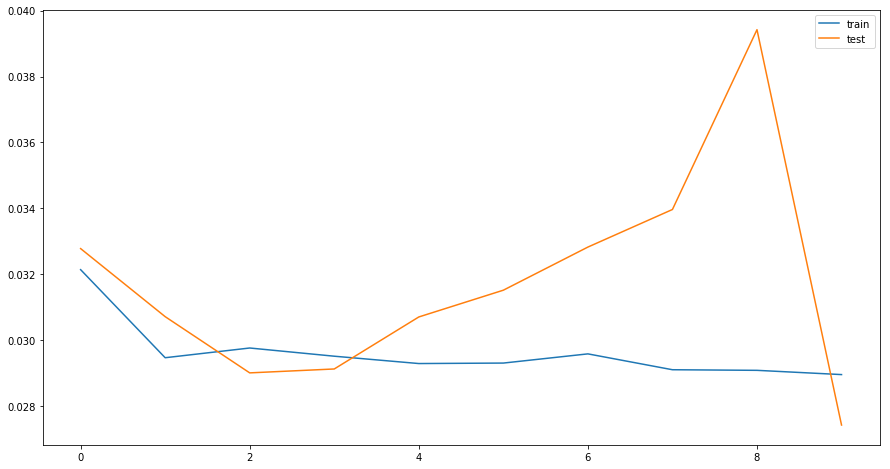

In [337]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [338]:
X_te_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [339]:
res = model_k.predict(X_te_reshaped)
print(X_te_reshaped)

[[[-0.39223227  0.         -0.43388757 ..., -0.35808054 -0.35789089
   -0.28226191]]

 [[-0.39223227  0.         -0.43388757 ..., -0.4335763  -0.35789089
   -0.35775544]]

 [[-0.39223227  0.         -0.35838783 ..., -0.4335763  -0.43338534
   -0.35775544]]

 ..., 
 [[-0.39223227  0.          0.17011035 ...,  0.09489397  0.24606473
    0.24619278]]

 [[-0.39223227  0.          0.09461061 ...,  0.09489397  0.09507583
    0.24619278]]

 [[-0.39223227  0.         -0.05638887 ...,  0.17038972  0.09507583
    0.09520573]]]


In [340]:
test_data["DL_PRED"] = res

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### LSTM Prediction on Test Data

In [359]:
keras_show = figure(plot_width=900, plot_height=350, x_axis_label="DATE_TIME", y_axis_label="value", x_axis_type="datetime")
keras_show.line(test_data["DATE_TIME"], test_data["USAGE"], legend="USAGE", color='navy', alpha=0.5)
keras_show.line(test_data["DATE_TIME"], test_data["RF_PREDICTED"], legend="RF_PREDICTED", color='olive', alpha=0.5)
keras_show.line(test_data["DATE_TIME"], test_data["DL_PRED"], legend="DL_PRED", color='firebrick', alpha=0.5)

show(keras_show)


#### A Day on LSTM Predcted Result

In [361]:
sep_30m = test_data[test_data.DATE_TIME >= pd.to_datetime("09/30/2017")]
sep_30 = figure(plot_width=900, plot_height=350, x_axis_label="DATE_TIME", y_axis_label="value", x_axis_type="datetime")
sep_30.line(sep_30m["DATE_TIME"], sep_30m["USAGE"], legend='USAGE',color='navy', alpha=0.5)
sep_30.line(sep_30m["DATE_TIME"], sep_30m["RF_PREDICTED"], legend='RF_PRED', color='olive', alpha=0.5)
sep_30.line(sep_30m["DATE_TIME"], sep_30m["DL_PRED"], legend='DL_PRED', color='firebrick', alpha=0.5)

show(sep_30)

#### RMSE Value of Random Forest and LSTM

In [363]:
from numpy import sqrt
sqrt(mean_squared_error(test_data.USAGE,test_data.DL_PRED))

0.12778110545554153

In [364]:
sqrt(mean_squared_error(test_data.USAGE,test_data.RF_PREDICTED))

0.18412616700088402